In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# Create class

class DyBePoModel:
    def __init__(self, initial_state, params=None):
        """
        Initialize the beehive population model.
        
        Args:
            initial_state (dict): Starting populations (default: {'E': 0, 'L': 0, 'P': 0, 'H': 0, 'F': 0, 'R': 0})
            params (dict): Optional dictionary to define hyper-parameters
        """
        # Unpack initial state
        self.E = initial_state.get('E', 0) # Egg
        self.L = initial_state.get('L', 0) # Larvae
        self.P = initial_state.get('P', 0) # Pupae
        self.D = initial_state.get('D', 0) # Drones
        self.H = initial_state.get('H', 0) # Hive Bee
        self.F = initial_state.get('F', 0) # Forager
        self.R = initial_state.get('R', 0) # Food Reserve
        self.state = {'E': self.E, 'L': self.L, 'P': self.P, 'D': self.D, 'H': self.H, 'F': self.F, 'R': self.R}
        
        # Default Parameters (values estimated from standard bee literature where not explicit in doc)
        self.params = {
            # Seasonality parameters
            'r0': 2000,       # Base egg-laying rate
            # Parameters x1-x5 from Section III-B, Eq. 2
            'x1': 385, 'x2': 30, 'x3': 36, 'x4': 155, 'x5': 30,
            
            # Transition rates
            'T_E': 1/3.0,     # Egg to Larvae
            'T_L': 1/5.0,     # Larvae to Pupae
            'T_P': 1/12.0,    # Pupae to Hive Bee
            
            # Mortality rates
            'M_E': 0.058,     # Egg mortality
            'M_P': 0.015,     # Pupae mortality
            
            # Resource parameters
            'rho': 0.1,       # Foraging efficiency
            'C_L': 0.02,     # Consumption by Larvae
            'C_H': 0.01,     # Consumption by Hive Bees
            'C_F': 0.01,     # Consumption by Foragers
            'C_D': 0.01,     # Consumption by Drones
            'w': 0.085,       # Weight of larvae (85mg = 0.085g) for cannibalism
            
            # Social transition parameters (Hive -> Forager)
            'alpha': 0.04, # Baseline transition rate (alpha)
            'beta': 0.01,   # Sensitivity to population/food ratio (beta)
            'sigma': 0.01,    # Social inhibition factor (sigma)
            'gamma': 0.01, # Larvae demand factor (gamma)
            
            # Other parameters
            'b': 500,         # Cannibalism constant
            'mu': 0.05,       # Drone ratio
            'delta': 0.5,     # Larvae care sensitivity exponent
            'healthy_ratio': 2.0 # (R_F^H)_Healthy
        }
        
        if params:
            self.params.update(params)

    # Auxiliary Formulas
    
    def _seasonality(self, t):
        # Equation 2: Sigmoidal seasonality function
        # s(t) = 1 - max(1 - 1/(1+x1*e^(-2t/x2)), 1/(1+x3*e^(-2(t-x4)/x5)))
        p = self.params
        term1 = 1 - 1 / (1 + p['x1'] * np.exp(-2 * (t % 365) / p['x2']))
        term2 = 1 / (1 + p['x3'] * np.exp(-2 * ((t % 365) - p['x4']) / p['x5']))
        return 1 - max(term1, term2)

    def _cannibalism_factor(self, R):
        # Equation 11
        # phi = 0.2 * (b^2 / (b^2 + R^2))
        b = self.params['b']
        return 0.2 * (b**2 / (b**2 + R**2))

    def _larvae_mortality(self, L, H, R):
        # Equation 12: Base mortality (M_L)_0
        if R <= 100:
            M_L0 = 0.15
        else:
            M_L0 = 0.083
            
        # Equation 4
        # M_L = min(1, M_L0 * (max(1, HealthyRatio / ActualRatio))^delta)
        if L == 0:
            ratio = 100 # Safe high value
        else:
            ratio = H / L
            
        care_factor = (max(1, self.params['healthy_ratio'] / ratio)) ** self.params['delta']
        return min(1, M_L0 * care_factor)

    def _drone_mortality(self, t, R):
        # Equation 14
        t_ = t % 365
        is_winter = (265 <= t_ <= 365) or (0 <= t_ <= 100) # Winter defined as such
        
        if is_winter:
            return 1.0 # 100% mortality in winter
        elif R <= 100:
            return 0.15
        else:
            return 0.03

    def _hive_mortality(self, R):
        # Equation 13
        if R <= 100:
            return 0.15
        else:
            return 0.01

    def _forager_mortality(self, t, R):
        # Equation 15, 16, 17
        # M_F(t, R) = m_s(t) * m(R)
        
        # Equation 16: Base m(R)
        if R <= 100:
            m_R = 0.3
        else:
            m_R = 0.1
            
        # Equation 17: Seasonal m_s(t)
        m_s_t = 0.15 + 0.85 * self._seasonality(t)
        
        return m_s_t * m_R

    def _transition_hive_to_forager(self, L, H, F, R, D):
        # Equation 9
        p = self.params
        
        # Numerator: 1 + beta * ((F + H + L) / R)
        total_pop = F + H + L
        
        # Safety check: avoid division by zero if R = 0
        R_safe = R if R > 1 else 1
        numerator = 1 + p['beta'] * (total_pop / R_safe)
        
        # Denominator Term 1: 1 + sigma * (F / (H + F))
        total_adults = H + F
        term1 = 1.0
        if total_adults > 0:
            term1 += p['sigma'] * (F / total_adults)
            
        # Denominator Term 2: 1 + gamma * (L / (H + L))
        total_nursing = H + L
        term2 = 1.0
        if total_nursing > 0:
            term2 += p['gamma'] * (L / total_nursing)
            
        # Final Calculation
        T_H = p['alpha'] * (numerator / (term1 * term2))
        
        return max(0, T_H)

    # Gradient
    
    def get_derivatives(self, t, state):
        """
        Calculates d/dt for all variables.
        This is the function the Solver will call.
        """
        E, L, P = state['E'], state['L'], state['P']
        D, H, F = state['D'], state['H'], state['F']
        R = state['R']
        p = self.params

        # Calculate helpers
        s_t = self._seasonality(t)
        M_L = self._larvae_mortality(L, H, R)
        M_H = self._hive_mortality(R)
        M_D = self._drone_mortality(t, R)
        M_F = self._forager_mortality(t, R)
        T_HF = self._transition_hive_to_forager(L, H, F, R, D)
        phi = self._cannibalism_factor(R)

        # Differential Equations
        
        # Eq 1: dE/dt = s(t)E0 - E*M_E - E*T_E
        dE = (s_t * p['r0']) - (E * p['M_E']) - (E * p['T_E'])
        
        # Eq 3: dL/dt = E*T_E - L*M_L - L*T_L
        dL = (E * p['T_E']) - (L * M_L) - (L * p['T_L'])
        
        # Eq 5: dP/dt = L*T_L - P*M_P - P*T_P
        dP = (L * p['T_L']) - (P * p['M_P']) - (P * p['T_P'])
        
        # Eq 6: dD/dt = mu * P * T_P - D * M_D (Drones)
        dD = (p['mu'] * P * p['T_P']) - (D * M_D)
        
        # Eq 7: dH/dt = (1-mu) * P * T_P - H*M_H - H*T_H
        dH = ((1 - p['mu']) * P * p['T_P']) - (H * M_H) - (H * T_HF)
        
        # Eq 8: dF/dt = H*T_H - F*M_F
        dF = (H * T_HF) - (F * M_F)
        
        # Eq 10: dR/dt = s(t)*rho*F - Consumption + Cannibalism
        consumption = (L * p['C_L']) + (H * p['C_H']) + (F * p['C_F']) + (D * p['C_D'])
        cannibalism = phi * (p['w'] * L * M_L)
        dR = (s_t * p['rho'] * F) - consumption + cannibalism

        return {'dE': dE, 'dL': dL, 'dP': dP, 'dD': dD, 'dH': dH, 'dF': dF, 'dR': dR}

In [3]:
# Approximation methods

def euler(current_state, t, dt, derivative_func):
    """
    Calculates the next state using Euler Method
    Formula: y_new = y + f(t, y) * dt
    """
    # Get the gradient at the current state
    derivs = derivative_func(t, current_state)
    
    new_state = {}
    for key in current_state:
        # Use max(0, ...) to ensure populations don't become negative
        change = derivs.get(f'd{key}', 0) * dt
        new_state[key] = max(0, current_state[key] + change)
        
    return new_state

def improved_euler(current_state, t, dt, derivative_func):
    """
    Calculates the next state using Improved Euler (Heun's) Method
    Formula:
    k1 = f(t, y)
    k2 = f(t + dt, y + k1 * dt)
    y_new = y + (dt/2) * (k1 + k2)
    """
    # Calculate slope k1
    k1 = derivative_func(t, current_state)
    
    # Predict the next state
    euler_pred = {}
    for key in current_state:
        change = k1.get(f'd{key}', 0) * dt
        euler_pred[key] = max(0, current_state[key] + change)
        
    # Calculate slope k2
    k2 = derivative_func(t + dt, euler_pred)
    
    # Average the slopes and update
    new_state = {}
    for key in current_state:
        slope_avg = 0.5 * (k1.get(f'd{key}', 0) + k2.get(f'd{key}', 0))
        new_state[key] = max(0, current_state[key] + slope_avg * dt)
        
    return new_state

def rk4(current_state, t, dt, derivative_func):
    """
    Calculates the next state using Runge-Kutta 4th Order (RK4) Method
    Formula:
    k1 = f(t, y)
    k2 = f(t + dt/2, y + k1 * dt/2)
    k3 = f(t + dt/2, y + k2 * dt/2)
    k4 = f(t + dt, y + k3 * dt)
    y_new = y + (dt/6) * (k1 + 2k2 + 2k3 + k4)
    """
    # Helper to create a temporary state based on a slope and a scale
    def get_temp_state(base_state, k_derivs, scale):
        res = {}
        for key in base_state:
            change = k_derivs.get(f'd{key}', 0) * scale
            res[key] = max(0, base_state[key] + change)
        return res

    # Calculate slope k1
    k1 = derivative_func(t, current_state)
    
    # Calculate slope k2
    state_k2 = get_temp_state(current_state, k1, dt / 2)
    k2 = derivative_func(t + dt / 2, state_k2)
    
    # Calculate k3
    state_k3 = get_temp_state(current_state, k2, dt / 2)
    k3 = derivative_func(t + dt / 2, state_k3)
    
    # Calculate k4
    state_k4 = get_temp_state(current_state, k3, dt)
    k4 = derivative_func(t + dt, state_k4)
    
    # Average the slopes and update
    new_state = {}
    for key in current_state:
        # Weighted sum: (k1 + 2k2 + 2k3 + k4) / 6
        slope_weighted = (k1.get(f'd{key}', 0) + 
                          2 * k2.get(f'd{key}', 0) + 
                          2 * k3.get(f'd{key}', 0) + 
                          k4.get(f'd{key}', 0)) / 6.0
        
        new_state[key] = max(0, current_state[key] + slope_weighted * dt)
        
    return new_state

In [4]:
# Graphing function (states with respect to time)
def plot_simulation_results(history):
    """
    Plots the trajectory of all beehive castes and resources over time.
    
    Args:
        history (list of dict): A list where each item is a dictionary 
                                containing 'time', 'E', 'L', 'P', 'H', 'F', 'R'.
    """
    # Extract data columns
    t_vals = [step['time'] for step in history]
    E_vals = [step['E'] for step in history]
    L_vals = [step['L'] for step in history]
    P_vals = [step['P'] for step in history]
    D_vals = [step['D'] for step in history]
    H_vals = [step['H'] for step in history]
    F_vals = [step['F'] for step in history]
    R_vals = [step['R'] for step in history]
    
    # Create the figure
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Population Castes on Left Y-Axis
    ax1.set_xlabel('Time (Days)')
    ax1.set_ylabel('Population Count', color='black')
    
    ax1.plot(t_vals, E_vals, label='Eggs', color='gold', linestyle='--')
    ax1.plot(t_vals, L_vals, label='Larvae', color='orange')
    ax1.plot(t_vals, P_vals, label='Pupae', color='brown')
    ax1.plot(t_vals, D_vals, label='Drone', color='purple')
    ax1.plot(t_vals, H_vals, label='Hive Bees', color='blue')
    ax1.plot(t_vals, F_vals, label='Foragers', color='green')
    
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, alpha=0.3)

    # Plot Resources on Right Y-Axis (Secondary Axis)
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Resources (grams)', color='red')
    ax2.plot(t_vals, R_vals, label='Resources', color='red', linewidth=2, linestyle=':')
    ax2.tick_params(axis='y', labelcolor='red')

    # Combine Legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

    plt.title('Beehive Population Dynamics & Resource Levels')
    plt.tight_layout()
    plt.show()

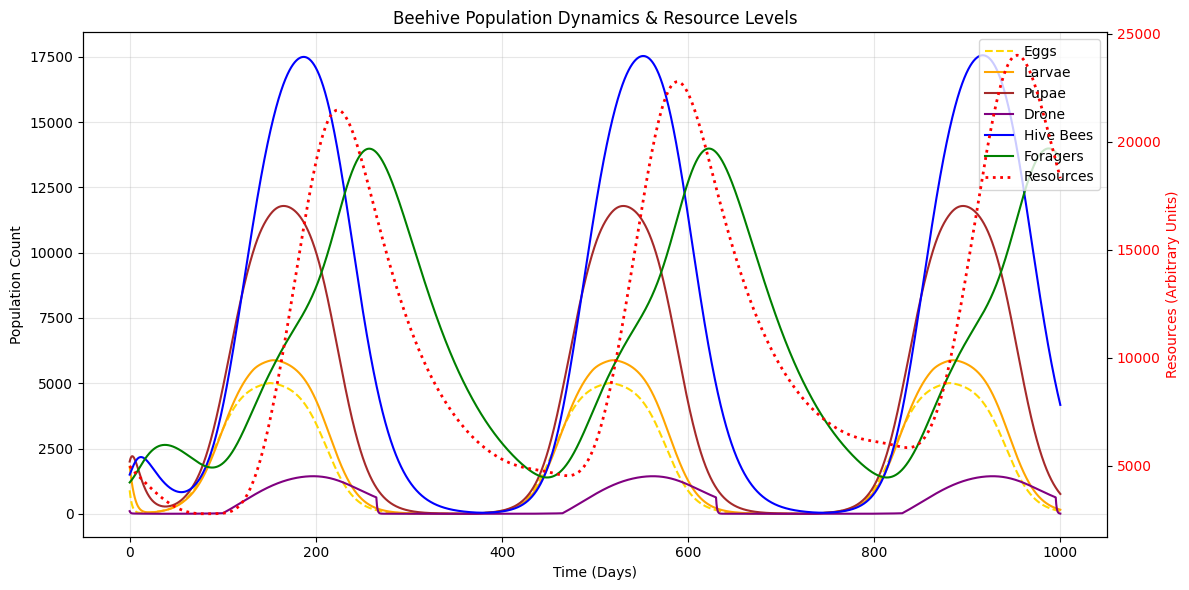

In [5]:
# Set initial value
initial_pops = {
    'E': 900,    # High egg laying (~1500/day * 3 days)
    'L': 1800,    # Many larvae to feed
    'P': 2000,   # Large developing brood
    'D': 100,    # Drones are present in summer
    'H': 1500,   # Strong workforce of nurses/builders
    'F': 1200,   # Large foraging force
    'R': 5000    # Good resource buffer
}
hive = DyBePoModel(initial_pops)

t = 0
dt = 0.1
days = 1000
history = []

# Run Loop
while t < days:
    history.append({**hive.state, 'time': t}) # Save state
    next_state = rk4(hive.state, t, dt, hive.get_derivatives) # Calculate next
    hive.state = next_state # Update
    t += dt
    
plot_simulation_results(history)

In [6]:
history[3650]

{'E': 0.2697557613246515,
 'L': 0.28412124205042966,
 'P': 1.7698823995758144,
 'D': 0.007897410033442218,
 'H': 65.13937587333429,
 'F': 4612.236432476069,
 'R': 6494.791346124222,
 'time': 365.0000000000145}